# Homework 4 

In [6]:
from tqdm import tqdm
import numpy as np
import os
import matplotlib.pyplot as plt

import cv2
from skimage.feature import hog
from skimage import exposure

# Task №1 - Whale Tail

Not long ago, there was a Kaggle competition for classifying humpback whales based on images of their tails. One of the techniques to improve the neural network's performance was to extract a mask of the tail. Using this mask, the tail was cropped from the original image, normalized, displayed on a black background, and then fed into the neural network.

Your task is to write a program that performs the preprocessing described above. Specifically:
- Find the tail mask,
- Crop the tail from the original image using the mask,
- Normalize the tail image so it always has a fixed size and occupies the space uniformly. If the tail is rotated, it should be straightened.

Tail images can be found in the folder `whale_tail/images` for this task. Ground truth masks are in the folder `whale_tail/ground_truth`. After extracting the tail, calculate the IoU for each image (using the masks from `whale_tail/ground_truth`).

<table><tr>
    <td> <img src="whale_tail/images/test_image_01.jpg" alt="Drawing" style="width: 400px;"/>
    <td> <img src="whale_tail/ground_truth/test_image_01.png" alt="Drawing" style="width: 400px;"/> </td>
</tr></table>


# IoU
Intersection over Union (IoU) is a value ranging from 0 to 1 that measures how much the "volume" of two objects (the ground truth and the current object) overlap.

<table><tr>
    <td> <img src="../img/iou.png" alt="Drawing" style="width: 400px;"/> </td>
</tr></table>


In [7]:
def ion2e(s):
    """
    Convert image filename from JPG to PNG format.

    :param s: original filename with '.jpg' extension
    :return: filename with '.png' extension
    """
    if s[-3:] == 'jpg':
        return s[:-3] + 'png'

# Function to load images and masks with resizing
def process_img_and_mask(images_dir, masks_dir, target_size=(256, 256)):
    """
    Load and preprocess images and masks from given directories.

    :param images_dir: directory containing the images
    :param masks_dir: directory containing the masks
    :param target_size: desired size for resizing (width, height)
    :return: dictionaries of processed images and masks
    """
    images = {}
    masks = {}
    for filename in os.listdir(images_dir):
        if filename.endswith(".jpg"):
            new_filename = ion2e(filename)
            img_path = os.path.join(images_dir, filename)
            mask_path = os.path.join(masks_dir, new_filename)
            if os.path.exists(mask_path):
                img = cv2.imread(img_path)
                img_resized = cv2.resize(img, target_size, interpolation=cv2.INTER_LINEAR)

                mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
                mask_resized = cv2.resize(mask, target_size, interpolation=cv2.INTER_NEAREST)

                images[filename] = img_resized
                masks[filename] = mask_resized
    return images, masks


In [8]:
images_dir = './whale_tail/images/'
masks_dir = './whale_tail/ground_truth/'
images, masks = process_img_and_mask(images_dir, masks_dir, target_size=(256, 256))

print(f"Loaded images: {len(images)}")
print(f"Loaded masks: {len(masks)}")


Loaded images: 6
Loaded masks: 6


In [11]:
# Function for processing an image
def process_image(image, mask, target_size=(256, 256)):
    masked_image = cv2.bitwise_and(image, image, mask=mask)
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return None, None

    largest_contour = max(contours, key=cv2.contourArea)
    rect = cv2.minAreaRect(largest_contour)
    box = cv2.boxPoints(rect)
    box = np.intc(box)

    width, height = target_size
    src_pts = np.array(box, dtype="float32")
    dst_pts = np.array([[0, height], [0, 0], [width, 0], [width, height]], dtype="float32")
    M = cv2.getPerspectiveTransform(src_pts, dst_pts)
    aligned_tail = cv2.warpPerspective(masked_image, M, target_size)

    predicted_mask = cv2.warpPerspective(mask, M, target_size)
    return aligned_tail, predicted_mask


In [12]:
# Function to calculate the IoU metric
def find_iou(predicted_mask, ground_truth_mask):
    intersection = np.logical_and(predicted_mask, ground_truth_mask).sum()
    union = np.logical_or(predicted_mask, ground_truth_mask).sum()
    return intersection / union if union != 0 else 0


In [13]:
# Processing all images and calculating IoU
def process_and_evaluate(images, masks, target_size=(256, 256)):
    iou_scores = {}
    for filename, image in images.items():
        mask = masks.get(filename)
        if mask is None:
            continue

        processed_image, predicted_mask = process_image(image, mask, target_size)
        if processed_image is None or predicted_mask is None:
            iou_scores[filename] = None
            continue

        # Convert masks for IoU calculation
        predicted_mask_binary = predicted_mask > 0
        ground_truth_binary = mask > 0

        # Calculate IoU
        iou_scores[filename] = find_iou(predicted_mask_binary, ground_truth_binary)

    return iou_scores


In [14]:
target_size = (256, 256)

iou_scores = process_and_evaluate(images, masks, target_size)
for filename, iou in iou_scores.items():
    print(f"{filename}: IoU = {iou:.4f}")

test_image_08.jpg: IoU = 0.1374
test_image_10.jpg: IoU = 0.6326
test_image_02.jpg: IoU = 0.3931
test_image_03.jpg: IoU = 0.1964
test_image_01.jpg: IoU = 0.4497
test_image_00.jpg: IoU = 0.3692


In [15]:
def display_results(images, processed_images, predicted_masks, num_images=5):
    """
    Display original images, processed images, and predicted masks.

    :param images: dictionary of original images
    :param processed_images: dictionary of processed images
    :param predicted_masks: dictionary of predicted masks
    :param num_images: number of images to display
    """
    filenames = list(images.keys())
    num_images = min(num_images, len(filenames))

    for i in range(num_images):
        filename = filenames[i]
        original = images[filename]
        processed = processed_images.get(filename)
        predicted_mask = predicted_masks.get(filename)

        plt.figure(figsize=(15, 5))
        plt.subplot(1, 3, 1)
        plt.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
        plt.title("Original Image")
        plt.axis("off")

        plt.subplot(1, 3, 2)
        if processed is not None:
            plt.imshow(cv2.cvtColor(processed, cv2.COLOR_BGR2RGB))
            plt.title("Processed Image")

        plt.subplot(1, 3, 3)
        if predicted_mask is not None:
            plt.imshow(predicted_mask, cmap="gray")
            plt.title("Predicted Mask")

        plt.show()


In [16]:
def process_and_save_with_display(images, masks, target_size=(256, 256)):
    """
    Process images, calculate IoU, and store processed images and predicted masks.

    :param images: dictionary of original images
    :param masks: dictionary of ground truth masks
    :param target_size: desired size for processed images and masks
    :return: IoU scores, processed images, and predicted masks
    """
    iou_scores = {}
    processed_images = {}
    predicted_masks = {}

    for filename, image in images.items():
        mask = masks.get(filename)
        if mask is None:
            continue

        processed_image, predicted_mask = process_image(image, mask, target_size)
        if processed_image is None or predicted_mask is None:
            iou_scores[filename] = None
            continue

        predicted_mask_binary = predicted_mask > 0
        ground_truth_binary = mask > 0
        iou_scores[filename] = find_iou(predicted_mask_binary, ground_truth_binary)

        processed_images[filename] = processed_image
        predicted_masks[filename] = predicted_mask

    return iou_scores, processed_images, predicted_masks


test_image_08.jpg: IoU = 0.1374
test_image_10.jpg: IoU = 0.6326
test_image_02.jpg: IoU = 0.3931
test_image_03.jpg: IoU = 0.1964
test_image_01.jpg: IoU = 0.4497
test_image_00.jpg: IoU = 0.3692


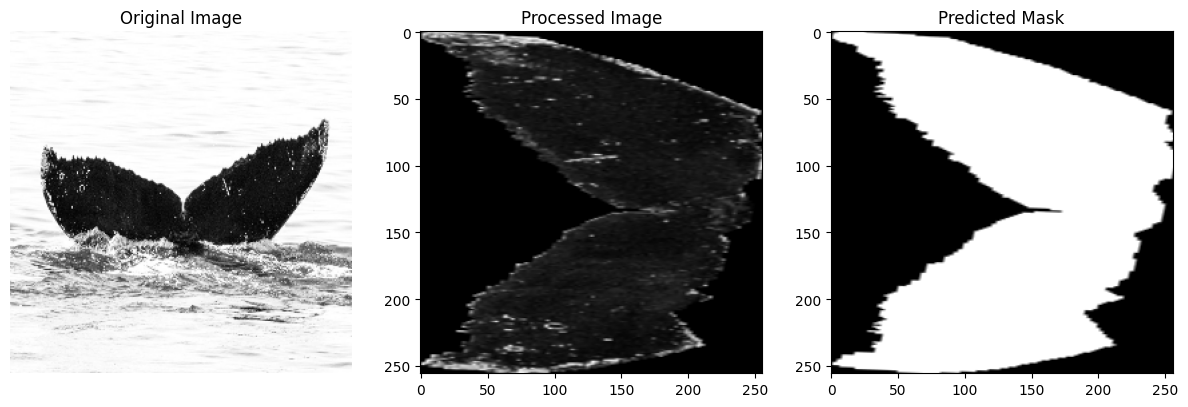

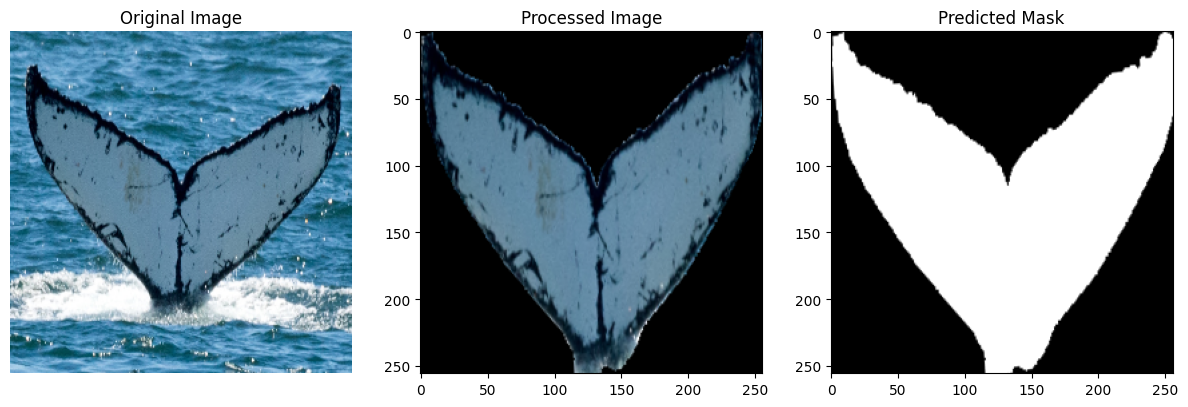

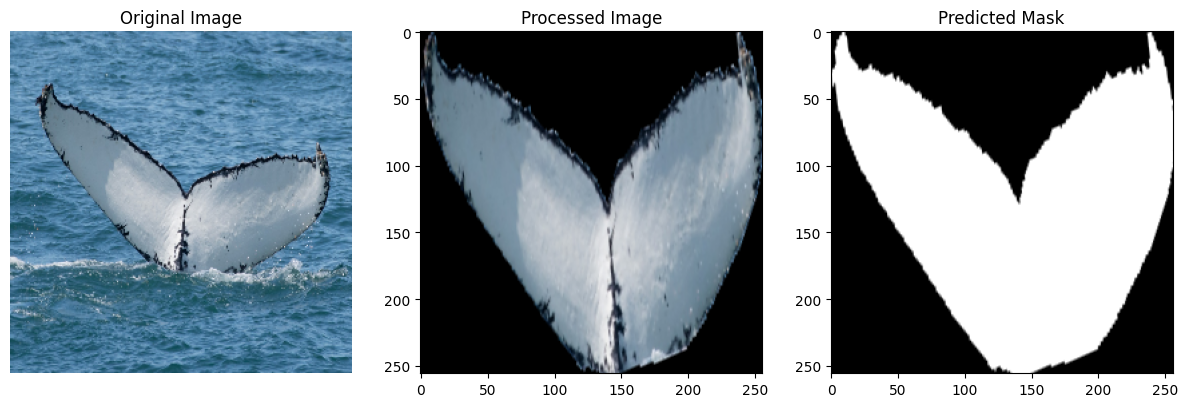

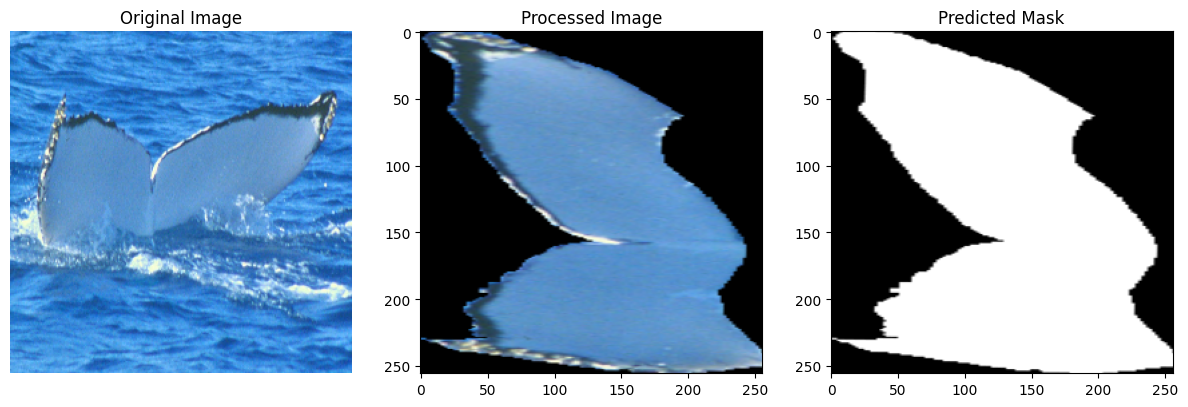

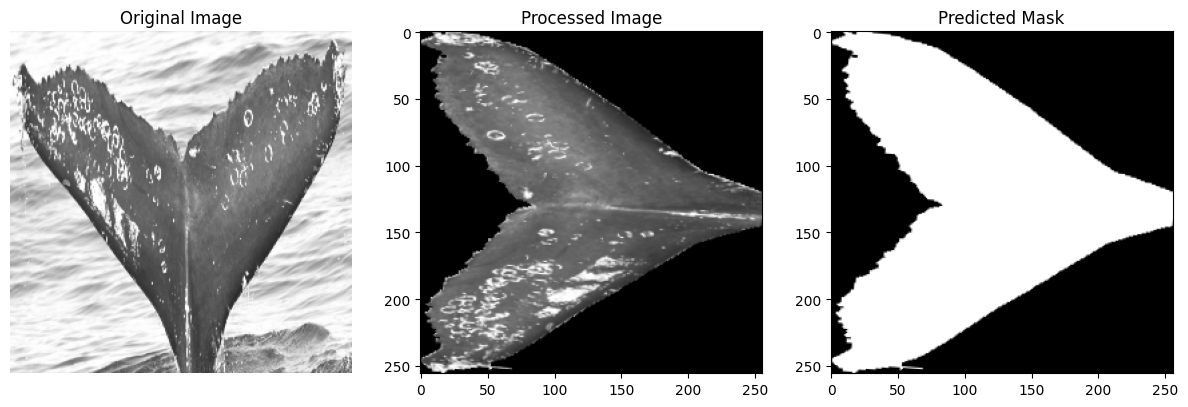

In [17]:
iou_scores, processed_images, predicted_masks = process_and_save_with_display(images, masks, target_size)
for filename, iou in iou_scores.items():
    print(f"{filename}: IoU = {iou:.4f}")

display_results(images, processed_images, predicted_masks, num_images=5)

# Task №2 - Find a Template in an Image Using HOG and Cross-Correlation

Your task is to write a program that can locate a template of a single eye in multiple images, including darkened ones. Use the HOG representation of the images, and perform template matching using cross-correlation.

The human eye image and the template to find are located in the `hog` folder.

<table><tr>
    <td> <img src="hog/eye.png" alt="Drawing" style="width: 400px;"/> </td>
</tr></table>

<table><tr>
    <td> <img src="hog/eyes.jpg" alt="Drawing" style="width: 400px;"/> </td>
    <td> <img src="hog/eyes_dark.jpg" alt="Drawing" style="width: 400px;"/> </td>
    <td> <img src="hog/woman.jpg" alt="Drawing" style="width: 200px;"/> </td>
</tr></table>


In [18]:
template_path = "./hog/eye.png"
template = cv2.imread(template_path, cv2.IMREAD_GRAYSCALE)

template_shape = template.shape

In [19]:
def preprocess_image(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) if len(image.shape) == 3 else image
    gray_image = cv2.equalizeHist(gray_image)
    blurred_image = cv2.GaussianBlur(gray_image, (5, 5), 0)

    return blurred_image

In [20]:
def compute_hog(image, pixels_per_cell=(8, 8), cells_per_block=(2, 2), orientations=9):
    fd, hog_image = hog(
        image, orientations=orientations, pixels_per_cell=pixels_per_cell,
        cells_per_block=cells_per_block, visualize=True
    )
    hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

    return fd, hog_image_rescaled


In [21]:
def find_eye_with_correlation(image, template, template_hog, template_shape):
    preprocessed_image = preprocess_image(image)

    result = cv2.matchTemplate(preprocessed_image, template, cv2.TM_CCOEFF_NORMED)

    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)
    window = preprocessed_image[max_loc[1]:max_loc[1]+template_shape[0], max_loc[0]:max_loc[0]+template_shape[1]]
    if window.shape == template_shape:
        window_hog, _ = compute_hog(window)
        score = np.sum(window_hog - template_hog)
    else:
        score = -1

    return max_loc, max_val, score

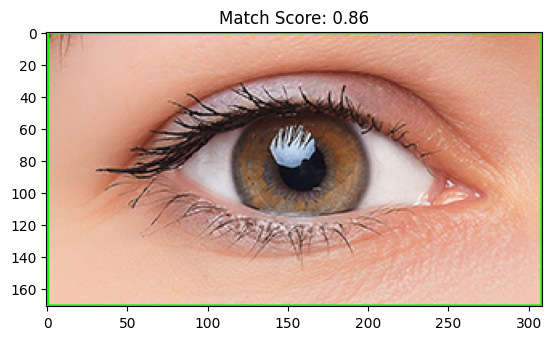

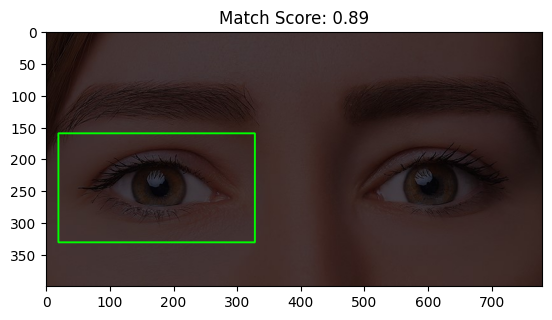

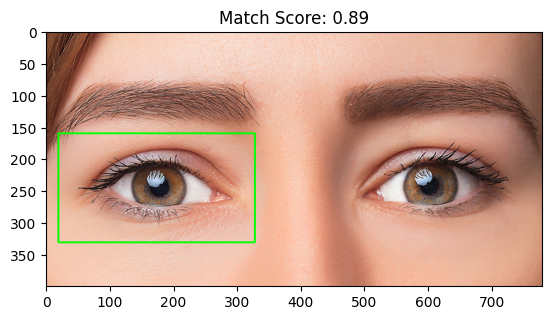

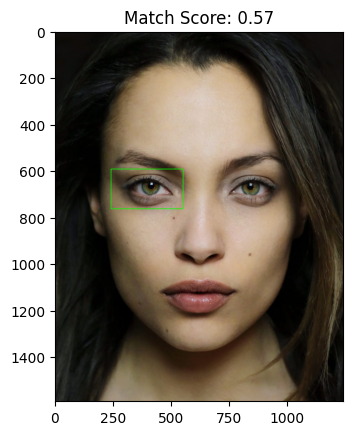

In [22]:
images = ["./hog/eye.png", "./hog/eyes_dark.jpg", "./hog/eyes.jpg", "./hog/woman.jpg"]

for image_path in images:
    image = cv2.imread(image_path)

    template_hog, _ = compute_hog(template)
    position, score, template_score = find_eye_with_correlation(image, template, template_hog, template_shape)

    if position:
        x, y = position
        h, w = template_shape
        cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)

    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(f"Match Score: {score:.2f}")
    plt.show()
